# Instruction

**Run each cell one by one**

#Load the dataset from the google drive

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pprint, pickle
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
id_1_train="1GFFtOkPJskSjhA7-Klfj33fF5eVWa5sE"
id_1_evaluation="1G7cd67MlLEBn-OoY612T08yBoRoGyXyd"


id_2_train="1AP5V-adbxm-bdOuB-7EtgegqzqtlldxZ"
id_2_evaluation="1-XoFS7lPF9DQSO4ItK_KtorUaLFmA4Pn"

id_3_train="1RFuUrqJPqBWycC_j1b2Vy1DgBr1yQbPG"
id_3_evaluation="1fPSYHnTi5ORcI7QgXjIduAYOYZsoE9tI"

id_4_train="1jovz85ALrSRBZgLNUeeoihSJkEYJT3ZH"
id_4_evaluation="1e6C3vn7sPV-LO-Q1EbLTHvlcT7oqhJ99"


id_5_train="17wrRD332sGeRob6W36MNkQmj9Kc6u5lG"
id_5_evaluation="1JUc3flvygXmhdTL-kM_9pvh25pKfpvNy"

id_6_train="1vROntA0I75Gq85VXa9jwukl-IXxEOCCb"
id_6_evaluation="1pYnce5N2KxxNmFM2sgfxldLpaKgclEiY"

id_7_train="1_qvjVphyrE311iInuVDhhWWWN3BC4-sm"
id_7_evaluation="18V-Tp3Kny9aYz8rxSFsRQrYDtstVF75d"


id_8_train="1Cpi6yNpnMX5oCClCClv7Lcgg2RvxspUF"
id_8_evaluation="13cz0_VMYI0-u2LlEhmy61mGuzmjbmP1B"

id_9_train="1o0gyOZrYsyw68GFhpKFuwoFRn4pVwb7Q"
id_9_evaluation="1KW0_TzquGXygyBksatKEvevm6NYwddEA"



def load(id_train,id_evaluation,subject):
  downloaded = drive.CreateFile({'id':id_train}) 
  downloaded.GetContentFile('A0'+str(subject)+'T.mat')
  downloaded = drive.CreateFile({'id':id_evaluation}) 
  downloaded.GetContentFile('A0'+str(subject)+'E.mat')

load(id_1_train,id_1_evaluation,1)
load(id_2_train,id_2_evaluation,2)
load(id_3_train,id_3_evaluation,3)

load(id_4_train,id_4_evaluation,4)
load(id_5_train,id_5_evaluation,5)
load(id_6_train,id_6_evaluation,6)

load(id_7_train,id_7_evaluation,7)
load(id_8_train,id_8_evaluation,8)
load(id_9_train,id_9_evaluation,9)



#Load the package

In [ ]:
import numpy as np
import scipy.io as sio
from tensorflow.keras.utils import to_categorical
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.function import Function
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plot
from sklearn.decomposition import PCA
import torch.utils.data as Data
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torchvision import models
from torchsummary import summary
import torch.optim.lr_scheduler as lr_scheduler


#Convert the data in mat format into Numpy array

In [ ]:
def load_all_data (crossValidation, data_path): 

    big_X_train, big_y_train, big_X_test, big_y_test = [None]*9, [None]*9, [None]*9, [None]*9
    for subject in range (0,9):
        path = data_path+'s' + str(subject+1) + '/'
        big_X_train[subject], big_y_train[subject] = get_data(subject+1, True ,path)
        big_X_test[subject], big_y_test[subject] = get_data(subject+1, False ,path)
    
    return big_X_train, big_y_train, big_X_test, big_y_test

def get_data_2(subject,training,path, highpass = False):
	'''	Loads the dataset 2a of the BCI Competition IV
	available on http://bnci-horizon-2020.eu/database/data-sets

	Keyword arguments:
	subject -- number of subject in [1, .. ,9]
	training -- if True, load training data
				if False, load testing data
	
	Return:	data_return 	numpy matrix 	size = NO_valid_trial x 22 x 1750
			class_return 	numpy matrix 	size = NO_valid_trial
	'''
	NO_channels = 22
	NO_tests = 6*48 	
	Window_Length = 7*250 

	class_return = np.zeros(NO_tests)
	data_return = np.zeros((NO_tests,NO_channels,Window_Length))

	NO_valid_trial = 0
	if training:
		a = sio.loadmat(path+'A0'+str(subject)+'T.mat')
	else:
		a = sio.loadmat(path+'A0'+str(subject)+'E.mat')
	a_data = a['data']
	for ii in range(0,a_data.size):
		a_data1 = a_data[0,ii]
		a_data2= [a_data1[0,0]]
		a_data3= a_data2[0]
		a_X 		= a_data3[0]
		a_trial 	= a_data3[1]
		a_y 		= a_data3[2]
		a_fs 		= a_data3[3]
		a_classes 	= a_data3[4]
		a_artifacts = a_data3[5]
		a_gender 	= a_data3[6]
		a_age 		= a_data3[7]

		for trial in range(0,a_trial.size):
			if(a_artifacts[trial]==0):
				data_return[NO_valid_trial,:,:] = np.transpose(a_X[int(a_trial[trial]):(int(a_trial[trial])+Window_Length),:22])
				class_return[NO_valid_trial] = int(a_y[trial])
				NO_valid_trial +=1

	return data_return[0:NO_valid_trial,:,:], class_return[0:NO_valid_trial]

def prepare_features(path,subject,crossValidation=False):
    fs = 250 
    # t1 = int(1.5*fs)
    t1 = int(2*fs)

    t2 = int(6*fs)
    T = t2-t1
    X_train, y_train = get_data_2(subject+1,True,path)
    # X_train, y_train,train_artifact = get_data_2(subject+1,True,path)

    if crossValidation:
        X_train, X_test, y_train, y_test = train_test_split(
            X_train, y_train, test_size=0.2, random_state=0)
    else:
        X_test, y_test = get_data_2(subject+1,False,path)

    # prepare training data 	
    N_tr,N_ch,_ =X_train.shape 
    X_train = X_train[:,:,t1:t2].reshape(N_tr,1,N_ch,T)
    y_train_onehot = (y_train-1).astype(int)
    y_train_onehot = to_categorical(y_train_onehot)
    # prepare testing data 
    N_test,N_ch,_ =X_test.shape 
    X_test = X_test[:,:,t1:t2].reshape(N_test,1,N_ch,T)
    y_test_onehot = (y_test-1).astype(int)
    y_test_onehot = to_categorical(y_test_onehot)	

    return X_train,y_train,y_train_onehot,X_test,y_test,y_test_onehot

#EEGNet

In [ ]:
class Constrainedlinear(nn.Linear):
    def _max_norm(self,w,max_val=0.25,eps=1e-8):
        norm = w.norm(2, dim=1, keepdim=True)
        desired = torch.clamp(norm, 0, max_val)
        return w * (desired / (eps + norm))
    def forward(self, input):
        return F.linear(input, self._max_norm(self.weight),self.bias)


class Constrainedlinear111(nn.Linear):
    def _max_norm(self,w,max_val=0.5,eps=1e-8):
        norm = w.norm(2, dim=1, keepdim=True)
        desired = torch.clamp(norm, 0, max_val)
        return w * (desired / (eps + norm))
    def forward(self, input):
        return F.linear(input, self._max_norm(self.weight),self.bias)


class EEGNet(nn.Module):
    def __init__(self, classes_num):
        super(EEGNet, self).__init__()
        self.numC=22

        self.drop_out = 0.2
        
        self.block_1 = nn.Sequential(
            # Pads the input tensor boundaries with zero
            # left, right, up, bottom
            nn.ZeroPad2d((15, 16, 0, 0)),
            nn.Conv2d(
                in_channels=1,          # input shape (1, C, T)
                out_channels=8,         # num_filters
                kernel_size=(1, 32),    # filter size
                bias=False
            ),                          # output shape (8, C, T)
            nn.BatchNorm2d(8)           # output shape (8, C, T)
        )
        
        # block 2 and 3 are implementations of Depthwise Convolution and Separable Convolution
        self.block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=8,          # input shape (8, C, T)
                out_channels=16,        # num_filters
                kernel_size=(self.numC, 1),    # filter size
                groups=8,
                bias=False
            ),                          # output shape (16, 1, T)
            nn.BatchNorm2d(16),         # output shape (16, 1, T)
            nn.ELU(),
            nn.AvgPool2d((1, 8)),       # output shape (16, 1, T//4)
            nn.Dropout(self.drop_out)   # output shape (16, 1, T//4)
        )
        
        self.block_3 = nn.Sequential(
            nn.ZeroPad2d((7, 8, 0, 0)),
            nn.Conv2d(
               in_channels=16,          # input shape (16, 1, T//4)
               out_channels=16,         # num_filters
               kernel_size=(1, 16),     # filter size
               groups=16,
               bias=False
            ),                          # output shape (16, 1, T//4)
            nn.Conv2d(
                in_channels=16,         # input shape (16, 1, T//4)
                out_channels=16,        # num_filters
                kernel_size=(1, 1),     # filter size
                bias=False
            ),                          # output shape (16, 1, T//4)
            nn.BatchNorm2d(16),         # output shape (16, 1, T//4)
            nn.ELU(),
            nn.AvgPool2d((1, 8)),       # output shape (16, 1, T//32)
            nn.Dropout(self.drop_out)
        )


        self.preluip1 = nn.PReLU()
        self.out = Constrainedlinear((16 * 15), classes_num)
    
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return F.log_softmax(x, dim=1) #x   # return x for visualization



#Load the raw data and assign the model

In [ ]:
def train(Subject_number):
  #Prepare the raw feature data for training and testing#
  #You can change the "Subject_number" (0-8 corresponding to B01-B09, respectively) to try training and testing between different subjects
  BATCH_SIZE = 128
  x_train,y_train,y_train_onehot,x_test,y_test,y_test_onehot = prepare_features('',Subject_number,False)
  
  total_x=np.vstack((x_train,x_test))
  total_y=np.hstack((y_train,y_test))
  index1=np.where(total_y == 1)[0]
  index2=np.where(total_y == 2)[0]
  index3=np.where(total_y == 3)[0]
  index4=np.where(total_y == 4)[0]
  print(total_y.shape)

  hyperparameter=10

  choice1=np.random.choice(index1,hyperparameter,replace=False)
  choice2=np.random.choice(index2,hyperparameter,replace=False)
  choice3=np.random.choice(index3,hyperparameter,replace=False)
  choice4=np.random.choice(index4,hyperparameter,replace=False)


  choice_total=np.hstack((choice1,choice2,choice3,choice4))
  
  target_x=total_x[choice_total]
  target_y=total_y[choice_total]
  xxxtest= np.delete(total_x, choice_total,0)
  yyytest=np.delete(total_y, choice_total)






  total_x_train=[]
  total_y_train=[]
  full_subjectnum=[0,1,2,3,4,5,6,7,8]
  full_subjectnum.remove(Subject_number)
  for train_subject in full_subjectnum:
    x_train,y_train,y_train_onehot,x_test,y_test,y_test_onehot = prepare_features('',train_subject,False)

    if len(total_x_train)==0:
      total_x_train=x_train
      total_y_train=y_train
    else:
      total_x_train=np.vstack((total_x_train,x_train))
      total_y_train=np.hstack((total_y_train,y_train))
    total_x_train=np.vstack((total_x_train,x_test))
    total_y_train=np.hstack((total_y_train,y_test))
  x_train=np.vstack((total_x_train,target_x))
  y_train=np.hstack((total_y_train,target_y))


  x_test=xxxtest
  y_test=yyytest
  print(x_train.shape)
  print(x_test.shape)


  x_train=torch.from_numpy(x_train)
  y_train=torch.from_numpy(y_train-1)
  x_test=torch.from_numpy(x_test)
  y_test=torch.from_numpy(y_test-1)
  x_train=x_train.float()
  x_test=x_test.float()
  y_train=y_train.long()
  y_test=y_test.long()
  train_dataset=Data.TensorDataset(x_train,y_train)
  val_dataset=Data.TensorDataset(x_test,y_test)

  

  #Construct the training Loader
  train_loader= Data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
  test_loader = Data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  eeg_net = EEGNet(classes_num=4).to(device)



  nllloss = nn.NLLLoss().to(device) #CrossEntropyLoss = log_softmax + NLLLoss

# optimzer4nn
  optimizer4nn = optim.Adam(eeg_net.parameters(),lr=0.001)

  #Define the number of epochs
  EPOCH=500

#Define the device
  DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  train_lossitem=[]
  test_lossitem=[]

  for epoch in range(EPOCH):
    loss_total=[]
    test_loss_total=[]

  #Update x_i using the gradient descent
    for step, (b_x, b_y) in enumerate(train_loader):
      b_x, b_y = b_x.to(DEVICE), b_y.to(DEVICE)
      output = eeg_net(b_x)
      loss = nllloss(output,b_y) 
      loss_total.append(loss.item())
      optimizer4nn.zero_grad()
      loss.backward()
      optimizer4nn.step()
    if epoch%2==0:
      train_lossitem.append(np.mean(loss_total))

    for step, (b_x, b_y) in enumerate(test_loader):
      b_x, b_y = b_x.to(DEVICE), b_y.to(DEVICE)
      output = eeg_net(b_x)
      loss = nllloss(output,b_y) 
      test_loss_total.append(loss.item())
    if epoch%2==0:

      test_lossitem.append(np.mean(test_loss_total))


    if epoch%100==0:
      print('Epoch: ', epoch, '| train loss: %.4f' % (np.mean(loss_total)),len(loss_total))
 
      eeg_net.eval()


      test_out = eeg_net(x_test.to(DEVICE))
      pred_y = torch.max(test_out.cpu(), 1)[1].data.numpy()
      accuracy = float((pred_y == y_test.data.numpy()).astype(int).sum()) / float(y_test.size(0))
      print("Subject "+str(Subject_number+1)+' test accuracy: %.4f' % accuracy)
      print('')
      eeg_net.train()

  return train_lossitem,test_lossitem


#Training

In [ ]:
Subject_number=0
train_lossitem,test_lossitem=train(Subject_number)

(554,)
(4182, 1, 22, 1000)
(514, 1, 22, 1000)
Epoch:  0 | train loss: 1.3709 33
Subject 1 test accuracy: 0.3482

Epoch:  100 | train loss: 0.7372 33
Subject 1 test accuracy: 0.7004

Epoch:  200 | train loss: 0.6670 33
Subject 1 test accuracy: 0.7140

Epoch:  300 | train loss: 0.6307 33
Subject 1 test accuracy: 0.7432

Epoch:  400 | train loss: 0.5929 33
Subject 1 test accuracy: 0.7374



In [ ]:
print(train_lossitem)
print(test_lossitem)

[1.3708823160691694, 1.2655361023816196, 1.2023339741157764, 1.151751615784385, 1.099466616457159, 1.058765810547453, 1.0207604982636191, 0.9985083702838782, 0.982788010077043, 0.9585227243828051, 0.9565384207349835, 0.9357095433003975, 0.927277254335808, 0.9114268494374824, 0.900260278672883, 0.8964734890244224, 0.887105436036081, 0.8769695090525078, 0.869256752910036, 0.8629036130327167, 0.8569768305980798, 0.8508534864945845, 0.8476952422748912, 0.8303388266852407, 0.8374481670784227, 0.8289132190473152, 0.8272480603420374, 0.8127754637689302, 0.8189054131507874, 0.8093513611591223, 0.8099648085507479, 0.8010025981700781, 0.8017637386466517, 0.7921409606933594, 0.7935316616838629, 0.7926189971692634, 0.7804791782841538, 0.7799635258587924, 0.7737393288901357, 0.7842045986291134, 0.7660735032775186, 0.7702492890935956, 0.765520433584849, 0.7654787934187687, 0.7626453403270606, 0.7576416748942751, 0.7534174738508282, 0.7470554583000414, 0.7399979016997598, 0.7432709318218809, 0.737165

# Plot

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


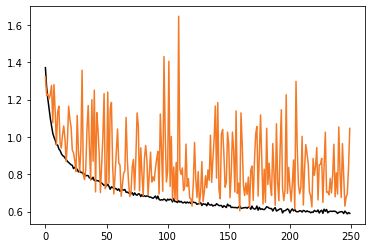

In [ ]:
# importing package
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import *

plt.rcParams.update({'font.family':'Verdana'})
  
# create data
x=list(range(len(train_lossitem)))
  
# plot lines
plt.plot(x, train_lossitem, label = "Training loss",color='black')
plt.plot(x, test_lossitem, label = "Testing loss",color='#F47A26')
plt.savefig('myimage.jpg', format='jpg', dpi=1200)

# plt.legend()
plt.show()